## XGBoost

[XGBoost](https://xgboost.readthedocs.io/en/latest/) is a well-known gradient boosted decision trees (GBDT) machine learning package used to tackle regression, classification, and ranking problems. XGBoost now includes seamless, drop-in GPU acceleration, which significantly speeds up model training and improves accuracy for better predictions. 

In this lab, you will learn how to train a XGBoost model easily to make predictions for your business.

Let's start with generating some fake dataset

In [15]:
from sklearn.datasets import make_classification, make_regression
import numpy as np
import cudf
import xgboost as xgb
# helper function for simulating data
def simulate_data(m, n, k=2, random_state=None, classification=True):
    if classification:
        #features, labels = make_classification(n_samples=m, n_features=n, 
        #                                       n_informative=int(n/5), n_classes=k,  n_redundant=0,
        #                                       random_state=random_state, n_clusters_per_class=3)
        features, labels = make_classification(m, n_features=n, n_informative=int(n/5),
                                               n_redundant=0, 
                                               n_clusters_per_class=2, 
                                               n_classes=k,
                                               class_sep=0.5, random_state=random_state)
        features = features.astype(np.float32)
    else:
        features, labels = make_regression(n_samples=m, n_features=n, 
                                           n_informative=int(n/5), n_targets=1, 
                                           random_state=random_state)
    
        features = features.astype(np.float32)
        labels = labels.astype(np.float32)
    df = cudf.DataFrame({i:features[:,i] for i in range(n)})
    df['label'] = labels
    return df

Generate a dataframe with 10 features where only 2 features are informatifve. The target variable is a binary variable indicatoring true or false state of the event.

In [16]:
length = 10000
n_cols = 10
data = simulate_data(length, n_cols, random_state=3, classification=True)
data

,0,1,2,3,4,5,6,7,8,9,label
0,-0.414371,0.170252,0.157776,-0.114504,-0.239577,0.348401,-1.039839,-0.132837,-0.999360,1.141326,0
1,-0.412286,-0.307401,-0.173051,-0.011609,-1.592140,0.842267,0.179028,-0.862772,-0.000078,1.005745,0
2,1.848268,-0.192474,0.021588,2.021024,-0.359771,-0.989047,-1.370592,-1.234139,0.944480,0.151289,0
3,0.809704,0.970889,1.998594,0.200990,-0.525432,0.123070,-0.896409,0.742980,1.808316,-1.956349,0
4,0.255245,0.690372,1.396018,1.804987,0.857866,-2.228087,-1.520161,0.462251,-0.274052,-0.712503,1
...,...,...,...,...,...,...,...,...,...,...,...
9995,-1.855639,1.082656,1.042976,-0.566071,0.272119,-0.253581,2.482289,0.482011,-1.072576,-0.305060,1
9996,-0.335521,0.668328,0.589292,-0.739626,0.565162,-0.596978,0.536728,0.103781,0.719949,2.002837,1
9997,1.539625,0.000535,-2.741257,1.741087,-0.507083,0.393023,-0.712878,0.520022,0.052463,-1.971740,0
9998,0.437912,-0.983853,-0.249036,0.092108,-1.411926,0.076247,-0.831038,-0.906514,-1.241225,0.349912,0


Split the dataset into training and validation datasets:

In [18]:
training_frac = 0.8
validation = int(length*training_frac)
train_df = data.iloc[:validation]
val_df = data.iloc[validation:]
dtrain = xgb.DMatrix(train_df[list(range(n_cols))], train_df['label'])
dval = xgb.DMatrix(val_df[list(range(n_cols))], val_df['label'])

We are ready to build the XGBoost model. Let's go over the popular parameter settings the XGBoost first.

## General Parameters

These define the overall functionality of XGBoost.

1. booster [default=gbtree]
    - Select the type of model to run at each iteration. It has 2 options:
        - gbtree: tree-based models
        - gblinear: linear models
2. silent [default=0]:
    - Silent mode is activated is set to 1, i.e. no running messages will be printed.
    - It’s generally good to keep it 0 as the messages might help in understanding the model.
 

## Booster Parameters
Though there are 2 types of boosters, I’ll consider only tree booster here because it always outperforms the linear booster and thus the later is rarely used.

1. eta [default=0.3]
    - Makes the model more robust by shrinking the weights on each step
    - Typical final values to be used: 0.01-0.2
2. min_child_weight [default=1]
    - Defines the minimum sum of weights of all observations required in a child.
3. max_depth [default=6]
    - Used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample.
    - Should be tuned using CV.
    - Typical values: 3-10
4. max_leaf_nodes
    - The maximum number of terminal nodes or leaves in a tree.
    - Can be defined in place of max_depth. Since binary trees are created, a depth of ‘n’ would produce a maximum of 2^n leaves.
5. gamma [default=0]
    - A node is split only when the resulting split gives a positive reduction in the loss function. Gamma specifies the minimum loss reduction required to make a split.
    - Makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.
6. subsample [default=1]
    - Denotes the fraction of observations to be randomly samples for each tree.
    - Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting.
    - Typical values: 0.5-1
7. colsample_bytree [default=1]
    - Denotes the fraction of columns to be randomly samples for each tree.
    - Typical values: 0.5-1
8. colsample_bylevel [default=1]
    - Denotes the subsample ratio of columns for each split, in each level.
    - I don’t use this often because subsample and colsample_bytree will do the job for you. but you can explore further if you feel so.
9. lambda [default=1]
    - L2 regularization term on weights (analogous to Ridge regression)
    - This used to handle the regularization part of XGBoost. Though many data scientists don’t use it often, it should be explored to reduce overfitting.
10. alpha [default=0]
    - L1 regularization term on weight (analogous to Lasso regression)
    - Can be used in case of very high dimensionality so that the algorithm runs faster when implemented
11. scale_pos_weight [default=1]
    - A value greater than 0 should be used in case of high class imbalance as it helps in faster convergence.
 

## Learning Task Parameters
These parameters are used to define the optimization objective the metric to be calculated at each step.

1. objective [default=reg:linear]
    - This defines the loss function to be minimized. Mostly used values are:
        - binary:logistic –logistic regression for binary classification, returns predicted probability (not class)
        - multi:softmax –multiclass classification using the softmax objective, returns predicted class (not probabilities)
            you also need to set an additional num_class (number of classes) parameter defining the number of unique classes
        - multi:softprob –same as softmax, but returns predicted probability of each data point belonging to each class.
2. eval_metric [ default according to objective ]
    - The metric to be used for validation data.
    - The default values are rmse for regression and error for classification.
    - Typical values are:
        - rmse – root mean square error
        - mae – mean absolute error
        - logloss – negative log-likelihood
        - error – Binary classification error rate (0.5 threshold)
        - merror – Multiclass classification error rate
        - mlogloss – Multiclass logloss
        - auc: Area under the curve
3. seed [default=0]
    - The random number seed.
    - Can be used for generating reproducible results and also for parameter tuning.
    
Let's start with a set of parameter to see what is the model performance

In [19]:
params={
          'learning_rate': 0.1,
          'colsample_bytree' : 0.3,
          'max_depth': 5,
          'num_parallel_tree':1,
          'objective': 'binary:logistic',
          'alpha' : 10,
          'silent': True,
          'tree_method':'gpu_hist',
          'eval_metric':'auc'}
## Train the model
trained_model = xgb.train(
                        params,
                        dtrain,
                        num_boost_round=100, evals=[(dtrain, 'train'), (dval, 'val')])

## Predict the model
prediction = trained_model.predict(dval)

[0]	train-auc:0.85606	val-auc:0.85519
[1]	train-auc:0.86294	val-auc:0.85197
[2]	train-auc:0.86236	val-auc:0.84689
[3]	train-auc:0.86452	val-auc:0.85543
[4]	train-auc:0.86520	val-auc:0.85488
[5]	train-auc:0.86670	val-auc:0.85487
[6]	train-auc:0.86424	val-auc:0.85263
[7]	train-auc:0.86536	val-auc:0.85656
[8]	train-auc:0.86588	val-auc:0.85782
[9]	train-auc:0.86643	val-auc:0.85879
[10]	train-auc:0.86725	val-auc:0.85917
[11]	train-auc:0.86772	val-auc:0.85944
[12]	train-auc:0.86908	val-auc:0.85925
[13]	train-auc:0.86928	val-auc:0.86099
[14]	train-auc:0.86992	val-auc:0.86117
[15]	train-auc:0.87091	val-auc:0.86181
[16]	train-auc:0.87140	val-auc:0.86204
[17]	train-auc:0.87191	val-auc:0.86209
[18]	train-auc:0.87249	val-auc:0.86238
[19]	train-auc:0.87288	val-auc:0.86274
[20]	train-auc:0.87318	val-auc:0.86353
[21]	train-auc:0.87379	val-auc:0.86316
[22]	train-auc:0.87426	val-auc:0.86332
[23]	train-auc:0.87475	val-auc:0.86314
[24]	train-auc:0.87534	val-auc:0.86316
[25]	train-auc:0.87536	val-auc:0.86

As we can see, the AUC score for validation dataset is 0.89, which is pretty good. 

## Exercise
Try to adjust the `num_boost_round` to see the effect in training

XGBoost also provides a Scikit-learn wrapper interface for XGBoost model, which makes it easy to use the tools inside Scikit-learn library. Let's train it with Scikit-learning API. 

In [20]:
from xgboost import XGBClassifier
model = XGBClassifier(**params)
model.fit(train_df[list(range(n_cols))].values.get(), train_df['label'].values.get())

XGBClassifier(alpha=10, base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, eval_metric='auc',
              gamma=0, gpu_id=0, importance_type='gain',
              interaction_constraints=None, learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=0,
              num_parallel_tree=1, random_state=0, reg_alpha=10, reg_lambda=1,
              scale_pos_weight=1, silent=True, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [ ]:
Check the model prediction vs the previous prediction results

In [21]:
np.abs(model.predict(val_df[list(range(n_cols))].values.get()) - (prediction >= 0.5).astype('int')).sum()

0

Since XGBClassifier is Scikit-learn compatible, we can easily do the hyper-parameters tuning by using `GridSearchCV`. E.g,  we would like to find out the best parameters for `learning_rate`, `max_depth`, `number of estimators`.

In [22]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
skf = StratifiedKFold(n_splits=4, shuffle = True, random_state = 1001)

params={
          'learning_rate': [0.2, 0.3, 0.4],
          'colsample_bytree' : [0.3],
          'max_depth': [5, 6, 7],
          'objective': ['binary:logistic'],
          'n_estimators':[100, 200],
          'alpha' : [10],
          'silent': [True],
          'tree_method':['gpu_hist'],
          'eval_metric':['auc']}
#model = XGBClassifier(**params)
#tparams={
#          'learning_rate': [0.1, 0.2, 0.3],
#          'max_depth': [5, 6, 7]}

grid_search = GridSearchCV(model, params, scoring='roc_auc', n_jobs=1, cv=skf, verbose=3)

grid_search.fit(train_df[list(range(n_cols))].values.get(), train_df['label'].values.get())

Fitting 4 folds for each of 18 candidates, totalling 72 fits
[CV] alpha=10, colsample_bytree=0.3, eval_metric=auc, learning_rate=0.2, max_depth=5, n_estimators=100, objective=binary:logistic, silent=True, tree_method=gpu_hist 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  alpha=10, colsample_bytree=0.3, eval_metric=auc, learning_rate=0.2, max_depth=5, n_estimators=100, objective=binary:logistic, silent=True, tree_method=gpu_hist, score=0.896, total=   0.4s
[CV] alpha=10, colsample_bytree=0.3, eval_metric=auc, learning_rate=0.2, max_depth=5, n_estimators=100, objective=binary:logistic, silent=True, tree_method=gpu_hist 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  alpha=10, colsample_bytree=0.3, eval_metric=auc, learning_rate=0.2, max_depth=5, n_estimators=100, objective=binary:logistic, silent=True, tree_method=gpu_hist, score=0.899, total=   0.4s
[CV] alpha=10, colsample_bytree=0.3, eval_metric=auc, learning_rate=0.2, max_depth=5, n_estimators=100, objective=binary:logistic, silent=True, tree_method=gpu_hist 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV]  alpha=10, colsample_bytree=0.3, eval_metric=auc, learning_rate=0.2, max_depth=5, n_estimators=100, objective=binary:logistic, silent=True, tree_method=gpu_hist, score=0.890, total=   0.4s
[CV] alpha=10, colsample_bytree=0.3, eval_metric=auc, learning_rate=0.2, max_depth=5, n_estimators=100, objective=binary:logistic, silent=True, tree_method=gpu_hist 
[CV]  alpha=10, colsample_bytree=0.3, eval_metric=auc, learning_rate=0.2, max_depth=5, n_estimators=100, objective=binary:logistic, silent=True, tree_method=gpu_hist, score=0.875, total=   0.4s
[CV] alpha=10, colsample_bytree=0.3, eval_metric=auc, learning_rate=0.2, max_depth=5, n_estimators=200, objective=binary:logistic, silent=True, tree_method=gpu_hist 
[CV]  alpha=10, colsample_bytree=0.3, eval_metric=auc, learning_rate=0.2, max_depth=5, n_estimators=200, objective=binary:logistic, silent=True, tree_method=gpu_hist, score=0.897, total=   0.7s
[CV] alpha=10, colsample_bytree=0.3, eval_metric=auc, learning_rate=0.2, max_depth=5, 

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   39.6s finished


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=1001, shuffle=True),
             estimator=XGBClassifier(alpha=10, base_score=0.5, booster=None,
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.3, eval_metric='auc',
                                     gamma=0, gpu_id=0, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=5, min_child_weight=1,
                                     m...
                                     scale_pos_weight=1, silent=True,
                                     subsample=1, tree_method='gpu_hist',
                                     validate_parameters=1, verbosity=None),
             n_jobs=1,
             param_grid={'alpha': [10], 'colsample_bytree': [0.3],
                         'eval_metric': ['auc

After the grid search, the best estimator is recorded at `grid_search.best_estimator_` with the best parameter set `grid_search.best_params_`

In [23]:
grid_search.best_params_

{'alpha': 10,
 'colsample_bytree': 0.3,
 'eval_metric': 'auc',
 'learning_rate': 0.2,
 'max_depth': 6,
 'n_estimators': 200,
 'objective': 'binary:logistic',
 'silent': True,
 'tree_method': 'gpu_hist'}

Let's check the performance on the validation dataset.

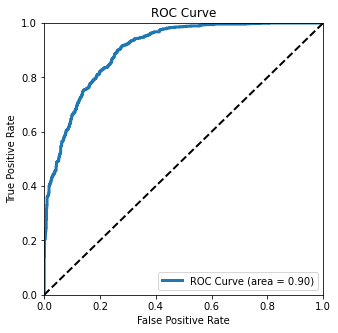

In [36]:
%matplotlib inline
from sklearn import metrics
import matplotlib.pyplot as plt
y_predictions = grid_search.best_estimator_.predict_proba(val_df[list(range(n_cols))].values.get())
fpr, tpr, thresholds = metrics.roc_curve(val_df['label'].values.get(), y_predictions[:,1])

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr, tpr, lw=3,
        label='ROC Curve (area = {:.2f})'.format(metrics.auc(fpr, tpr)))
ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    title="ROC Curve",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend();
plt.show()

## Exercise

Try to use grid search to tune other hyper-parameters to see whether you can make the ROC result better:

## Forest Inference Library

The open source Forest Inference Library (FIL) in RAPIDS can accelerate GBDT and RF inference with GPUs. Users can train models as usual in XGBoost or LightGBM, save them to disk, then use FIL to reload those models and apply them to new data. Using FIL, a single V100 GPU can deliver up to 35x more inference throughput than a CPU-only node with 40 cores. For more details, please refer to this [blog](https://medium.com/rapids-ai/rapids-forest-inference-library-prediction-at-100-million-rows-per-second-19558890bc35).

The XGBoost model can be serialized to disk by `save_model` command:

In [37]:
grid_search.best_estimator_.save_model('best.model')

It is very easy to use Forest Inference Library. Simply load the model and make prediction. 

In [40]:
from cuml import ForestInference
fm = ForestInference.load('best.model', output_class=True)

fil_preds_gpu = fm.predict(val_df[list(range(n_cols))])
fil_preds_gpu

0       1.0
1       0.0
2       0.0
3       1.0
4       0.0
       ... 
1995    1.0
1996    1.0
1997    0.0
1998    0.0
1999    0.0
Length: 2000, dtype: float32

## Multiple GPU XGBoost

Single GPU can only fit the size of the data that the memory allows. To train a large dataset, distributed XGBoost training is the solution. Luckily, dask XGBoost integration make distributed XGBoost training an easy task to do.

### Create a Cluster and Client
Let's start by creating a local cluster of workers and a client to interact with that cluster.

In [1]:

from dask.distributed import Client
from dask_cuda import LocalCUDACluster
import dask_cudf
import dask
# create a local CUDA cluster
cluster = LocalCUDACluster()
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:42775 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 270.39 GB


We can generate the synthetic distributed dataset by `dask_ml.datasets.make_classification_df` method. It creates `dask_cudf` dataframe with specified chunks. Dask can automatically breakdown the computation into small tasks and schedule the computation in a cluster of GPUs.  

In [43]:
import dask_ml.datasets
import dask_xgboost
length = 10000
train_frac = 0.8
chunks = 100
validation_chunks = int(train_frac * chunks)
df = dask_ml.datasets.make_classification_df(n_samples=length, chunks=chunks)
df

(Dask DataFrame Structure:
                     var0     var1     var2     var3     var4     var5     var6     var7     var8     var9    var10    var11    var12    var13    var14    var15    var16    var17    var18    var19
 npartitions=100                                                                                                                                                                                    
 0                float64  float64  float64  float64  float64  float64  float64  float64  float64  float64  float64  float64  float64  float64  float64  float64  float64  float64  float64  float64
 100                  ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...
 ...                  ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      ...      .

We can see the `dask_cudf` dataframe has 100 partitions that will be distributed in computation. The dataframe numbers are empty due to the Dask laze computation design. We can split the dask_cudf dataframe into train and validation datasets at the level of partitions. Note, we use the dask low level API `to_delayed` to get the delayed objects

In [6]:
delayed_x_chunks = df[0].to_delayed()
delayed_y_chunks = df[1].to_delayed()
train_x_dask_df = dask_cudf.from_delayed(delayed_x_chunks[:validation_chunks])
train_y_dask_df = dask_cudf.from_delayed(delayed_y_chunks[:validation_chunks])
val_x_dask_df = dask_cudf.from_delayed(delayed_x_chunks[validation_chunks:])
val_y_dask_df = dask_cudf.from_delayed(delayed_y_chunks[validation_chunks:])

In [85]:
#dtrain = xgb.DMatrix(dask_df[list(range(20))], dask_df['label'])
params={
          'learning_rate': 0.1,
          'colsample_bytree' : 0.3,
          'max_depth': 5,
          'num_parallel_tree':1,
          'objective': 'binary:logistic',
          'alpha' : 10,
          'silent': True,
          'tree_method':'gpu_hist',
          'eval_metric':'auc'}
dtrain = xgb.dask.DaskDMatrix(client, train_x_dask_df, train_y_dask_df)
dval = xgb.dask.DaskDMatrix(client, val_x_dask_df, val_y_dask_df)
bst = xgb.dask.train(client, params, dtrain, num_boost_round=100, evals=[(dtrain, 'train'), (dval, 'val')])

Plot the training curves

Text(0.5, 0, 'round')

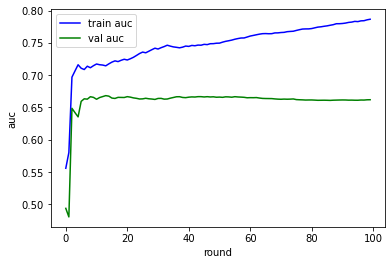

In [86]:
plt.plot(bst['history']['train']['auc'], 'b-', label='train auc')
plt.plot(bst['history']['val']['auc'], 'g-', label='val auc')
plt.legend()
plt.ylabel('auc')
plt.xlabel('round')

We can check the ROC curve for both train the val dataset.

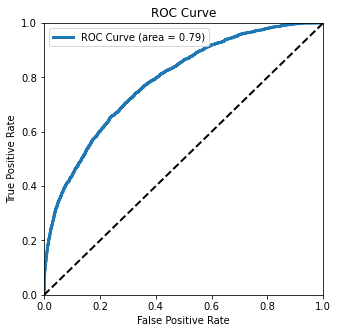

In [87]:
%matplotlib inline
from sklearn import metrics
import matplotlib.pyplot as plt
y_predictions = xgb.dask.predict(client, bst, dtrain)
train_y_dask_df.compute()
y_predictions.compute()
fpr, tpr, thresholds = metrics.roc_curve(train_y_dask_df.compute(), y_predictions.compute())

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr, tpr, lw=3,
        label='ROC Curve (area = {:.2f})'.format(metrics.auc(fpr, tpr)))
ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    title="ROC Curve",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend();
plt.show()



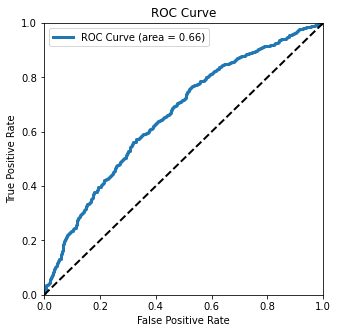

In [64]:
y_predictions = xgb.dask.predict(client, bst, dval)
train_y_dask_df.compute()
y_predictions.compute()
fpr, tpr, thresholds = metrics.roc_curve(val_y_dask_df.compute(), y_predictions.compute())

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(fpr, tpr, lw=3,
        label='ROC Curve (area = {:.2f})'.format(metrics.auc(fpr, tpr)))
ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    title="ROC Curve",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
)
ax.legend();
plt.show()

The feature importance score is reported in the XGBoost model. This information can be used to find out the features that has impacts on the prediction. 

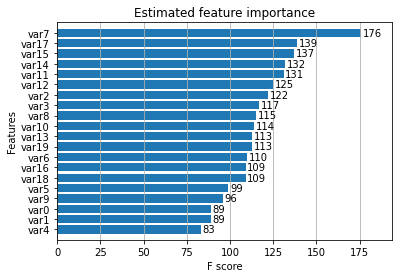

In [88]:
ax = xgb.plot_importance(bst['booster'], height=0.8, max_num_features=20)
ax.grid(False, axis="y")
ax.set_title('Estimated feature importance')
plt.show()

## Homework

XGBoost works for both classification problem and regression problem. Change the target variable to continuous variable and try to follow the above steps but work on a regression problem.